In [ ]:
import pandas as pd
import kagglehub

# Download the dataset
path = kagglehub.dataset_download("sid321axn/beijing-multisite-airquality-data-set")
print("Path to dataset files:", path)

# File names to be processed
list_filenames = [
    "PRSA_Data_Guanyuan_20130301-20170228.csv",
    "PRSA_Data_Aotizhongxin_20130301-20170228.csv",
    "PRSA_Data_Wanliu_20130301-20170228.csv",
    "PRSA_Data_Tiantan_20130301-20170228.csv",
    "PRSA_Data_Wanshouxigong_20130301-20170228.csv",
    "PRSA_Data_Nongzhanguan_20130301-20170228.csv",
    "PRSA_Data_Shunyi_20130301-20170228.csv",
    "PRSA_Data_Changping_20130301-20170228.csv",
    "PRSA_Data_Dingling_20130301-20170228.csv",
    "PRSA_Data_Huairou_20130301-20170228.csv",
    "PRSA_Data_Gucheng_20130301-20170228.csv",
    "PRSA_Data_Dongsi_20130301-20170228.csv"
]

# Load datasets into a list of dataframes
dataframes = []
for filename in list_filenames:
    full_path = f"{path}/{filename}"
    df = pd.read_csv(full_path)
    df['site'] = filename.split('_')[2]  # Add site identifier
    dataframes.append(df)

# Combine all dataframes into one
combined_data = pd.concat(dataframes, ignore_index=True)

# Display combined data structure
print("Combined Dataset Info:")
print(combined_data.info())

100%|██████████| 8.58M/8.58M [00:00<00:00, 10.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/sid321axn/beijing-multisite-airquality-data-set/versions/1
Combined Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420768 entries, 0 to 420767
Data columns (total 19 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   No       420768 non-null  int64  
 1   year     420768 non-null  int64  
 2   month    420768 non-null  int64  
 3   day      420768 non-null  int64  
 4   hour     420768 non-null  int64  
 5   PM2.5    412029 non-null  float64
 6   PM10     414319 non-null  float64
 7   SO2      411747 non-null  float64
 8   NO2      408652 non-null  float64
 9   CO       400067 non-null  float64
 10  O3       407491 non-null  float64
 11  TEMP     420370 non-null  float64
 12  PRES     420375 non-null  float64
 13  DEWP     420365 non-null  float64
 14  RAIN     420378 non-null  float64
 15  wd       418946 non-null  object 
 16  WSPM     420450 non-null  float64
 17  statio

In [ ]:
import pandas as pd
import numpy as np

# Create a datetime column
combined_data['datetime'] = pd.to_datetime(combined_data[['year', 'month', 'day', 'hour']])

# Sort the dataset by datetime
combined_data = combined_data.sort_values(by='datetime')

# Verify the update
print("Data sorted by datetime successfully.")
print(combined_data[['datetime', 'year', 'month', 'day', 'hour']].head())

# Sort data by time for temporal consistency
combined_data = combined_data.sort_values(by='datetime')

# Inspect missing values
missing_summary = combined_data.isnull().sum()

# Drop columns with too many missing values or irrelevant ones
threshold = 0.5 * len(combined_data)  # Drop columns with >50% missing
combined_data_cleaned = combined_data.dropna(axis=1, thresh=threshold)

# Fill remaining missing values with forward fill or a constant
combined_data_cleaned = combined_data_cleaned.fillna(method='ffill').fillna(0)

# Feature Engineering
# Add temporal features
combined_data_cleaned['hour'] = combined_data_cleaned['datetime'].dt.hour
combined_data_cleaned['day'] = combined_data_cleaned['datetime'].dt.day
combined_data_cleaned['month'] = combined_data_cleaned['datetime'].dt.month
combined_data_cleaned['year'] = combined_data_cleaned['datetime'].dt.year
combined_data_cleaned['day_of_week'] = combined_data_cleaned['datetime'].dt.dayofweek
combined_data_cleaned['is_weekend'] = combined_data_cleaned['day_of_week'].isin([5, 6]).astype(int)

# Add a target variable for 7-day ahead prediction
combined_data_cleaned['target_7_days_ahead'] = combined_data_cleaned['PM2.5'].shift(-7)  # Shift PM2.5 by 7 days

# Add spatial granularity (e.g., site-level feature, which corresponds to city_id)
# Assuming 'site' column exists in the dataset
combined_data_cleaned['city_id'] = combined_data_cleaned['site'].astype('category').cat.codes

# Generate lag features for AQI or other pollutants
lag_features = ['PM2.5', 'PM10', 'O3']  # Replace with relevant column names
for feature in lag_features:
    for lag in range(1, 8):  # Create lag features for up to 7 days
        combined_data_cleaned[f'{feature}_lag_{lag}'] = combined_data_cleaned[feature].shift(lag)

# Generate rolling statistics
for feature in lag_features:
    combined_data_cleaned[f'{feature}_rolling_mean'] = combined_data_cleaned[feature].rolling(window=7).mean()
    combined_data_cleaned[f'{feature}_rolling_std'] = combined_data_cleaned[feature].rolling(window=7).std()

# Drop rows with NaN values introduced by rolling or lagging
combined_data_cleaned = combined_data_cleaned.dropna()

# Save cleaned and feature-engineered data to a CSV for further use
combined_data_cleaned.to_csv('processed_beijing_airquality_data.csv', index=False)

# Output dataset structure and head
print("Processed Dataset Info:")
print(combined_data_cleaned.info())
print(combined_data_cleaned.head())


Data sorted by datetime successfully.
         datetime  year  month  day  hour
0      2013-03-01  2013      3    1     0
315576 2013-03-01  2013      3    1     0
70128  2013-03-01  2013      3    1     0
350640 2013-03-01  2013      3    1     0
35064  2013-03-01  2013      3    1     0


<ipython-input-6-f1ecf49959b3>:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  combined_data_cleaned = combined_data_cleaned.fillna(method='ffill').fillna(0)


Processed Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 420754 entries, 35064 to 175319
Data columns (total 51 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   No                   420754 non-null  int64         
 1   year                 420754 non-null  int32         
 2   month                420754 non-null  int32         
 3   day                  420754 non-null  int32         
 4   hour                 420754 non-null  int32         
 5   PM2.5                420754 non-null  float64       
 6   PM10                 420754 non-null  float64       
 7   SO2                  420754 non-null  float64       
 8   NO2                  420754 non-null  float64       
 9   CO                   420754 non-null  float64       
 10  O3                   420754 non-null  float64       
 11  TEMP                 420754 non-null  float64       
 12  PRES                 420754 non-null  float64    

In [ ]:
!pip install keras-tuner


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt
from sklearn.preprocessing import StandardScaler

# Assuming 'combined_data_cleaned' is the processed dataset (DataFrame)

# Identify numeric columns (this includes all engineered features)
numeric_columns = combined_data_cleaned.select_dtypes(include=[np.number]).columns

# Step 1: Prepare the data for LSTM with new features
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length, :-1])  # features (exclude target)
        y.append(data[i+sequence_length, -1])    # target variable (PM2.5)
    return np.array(X), np.array(y)

sequence_length = 7  # Use the last 7 days to predict the next day
X, y = create_sequences(combined_data_cleaned[numeric_columns].values, sequence_length)

# Split data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Normalize the data
scaler = StandardScaler()

# X_train and X_test are 3D arrays (samples, time steps, features) for LSTM, scaling should be applied per feature
X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])  # Flatten the time steps for scaling
X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])

X_train_scaled = scaler.fit_transform(X_train_reshaped).reshape(X_train.shape)  # Reshape back to 3D
X_test_scaled = scaler.transform(X_test_reshaped).reshape(X_test.shape)  # Reshape back to 3D

# Step 2: Build the LSTM Model (for hyperparameter tuning)
def build_lstm_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=128, step=32),
                   return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(Dense(1))  # Output the prediction (PM2.5 value)
    model.compile(optimizer='adam', loss='mse')
    return model

# Initialize Keras Tuner for LSTM tuning
tuner = kt.Hyperband(build_lstm_model, objective='val_loss', max_epochs=10, factor=3, directory='my_dir', project_name='lstm_tuning')

# Perform the tuning
tuner.search(X_train_scaled, y_train, epochs=10, validation_data=(X_test_scaled, y_test))

# Best hyperparameters for LSTM
best_lstm_hp = tuner.get_best_hyperparameters()[0]
print("Best LSTM hyperparameters:", best_lstm_hp.values)

# Step 3: Train the Best LSTM Model with Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)

lstm_model = build_lstm_model(best_lstm_hp)
lstm_model.fit(X_train_scaled, y_train, epochs=20, batch_size=32, validation_data=(X_test_scaled, y_test), callbacks=[early_stopping])

# Step 4: Get LSTM Predictions (or hidden states) to use as features for XGBoost
lstm_preds_train = lstm_model.predict(X_train_scaled)
lstm_preds_test = lstm_model.predict(X_test_scaled)

# Save LSTM predictions for next part (XGBoost)
np.save('lstm_preds_train.npy', lstm_preds_train)
np.save('lstm_preds_test.npy', lstm_preds_test)

# You can also save the model if you need to
lstm_model.save('best_lstm_model.h5')


Trial 4 Complete [00h 06m 48s]
val_loss: 15.301602363586426

Best val_loss So Far: 15.301602363586426
Total elapsed time: 00h 17m 33s
Best LSTM hyperparameters: {'units': 128, 'tuner/epochs': 2, 'tuner/initial_epoch': 0, 'tuner/bracket': 2, 'tuner/round': 0}
Epoch 1/20
10519/10519 ━━━━━━━━━━━━━━━━━━━━ 164s 15ms/step - loss: 91.4745 - val_loss: 23.6256
Epoch 2/20
10519/10519 ━━━━━━━━━━━━━━━━━━━━ 160s 15ms/step - loss: 35.6649 - val_loss: 15.7295
Epoch 3/20
10519/10519 ━━━━━━━━━━━━━━━━━━━━ 205s 15ms/step - loss: 23.5032 - val_loss: 14.7250
Epoch 4/20
10519/10519 ━━━━━━━━━━━━━━━━━━━━ 196s 15ms/step - loss: 20.3721 - val_loss: 13.3188
Epoch 5/20
10519/10519 ━━━━━━━━━━━━━━━━━━━━ 199s 15ms/step - loss: 16.6308 - val_loss: 13.2581
Epoch 6/20
10519/10519 ━━━━━━━━━━━━━━━━━━━━ 162s 15ms/step - loss: 14.1335 - val_loss: 12.2565
Epoch 7/20
10519/10519 ━━━━━━━━━━━━━━━━━━━━ 197s 15ms/step - loss: 13.1301 - val_loss: 12.5336
Epoch 8/20
10519/10519 ━━━━━━━━━━━━━━━━━━━━ 208s 15ms/step - loss: 11.9963 -

In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import keras_tuner as kt

# Load the saved LSTM predictions (this assumes the LSTM model has been trained already)
lstm_preds_train = np.load('lstm_preds_train.npy')
lstm_preds_test = np.load('lstm_preds_test.npy')

# Check the lengths of LSTM predictions
print(f"Length of lstm_preds_train: {len(lstm_preds_train)}")
print(f"Length of lstm_preds_test: {len(lstm_preds_test)}")

# Check the length of the combined dataset
print(f"Length of combined_data_cleaned: {len(combined_data_cleaned)}")

# Flatten the predictions to 1D arrays (if needed)
lstm_preds_train = lstm_preds_train.flatten()
lstm_preds_test = lstm_preds_test.flatten()

# Concatenate the predictions
lstm_preds = np.concatenate([lstm_preds_train, lstm_preds_test])

# If the lengths don't match, extend lstm_preds with NaN values to match the original data length
if len(lstm_preds) < len(combined_data_cleaned):
    lstm_preds = np.pad(lstm_preds, (0, len(combined_data_cleaned) - len(lstm_preds)), constant_values=np.nan)

# Add LSTM predictions as a feature to the dataset
combined_data_cleaned['lstm_preds'] = lstm_preds

# Now we can proceed with XGBoost model, where lstm_preds are added as a feature
# Step 5: Prepare Data for XGBoost
X = combined_data_cleaned[['PM2.5_lag_1', 'PM10_lag_1', 'O3_lag_1', 'PM2.5_rolling_mean', 'PM10_rolling_mean', 'O3_rolling_mean', 'lstm_preds']]
y = combined_data_cleaned['target_7_days_ahead']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize data for XGBoost
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Ensure y_train is sliced to match the size of X_train_scaled
y_train = y_train[:X_train_scaled.shape[0]]

# Slice X_train_scaled to match the size of lstm_preds_train
X_train_scaled = X_train_scaled[:len(lstm_preds_train)]

# Combine LSTM predictions with other features for XGBoost (train set)
X_train_xgb = np.column_stack([lstm_preds_train[:X_train_scaled.shape[0]], X_train_scaled])

# Adjust the length of lstm_preds_test to match X_test_scaled
if len(lstm_preds_test) > X_test_scaled.shape[0]:
    lstm_preds_test = lstm_preds_test[:X_test_scaled.shape[0]]
elif len(lstm_preds_test) < X_test_scaled.shape[0]:
    X_test_scaled = X_test_scaled[:len(lstm_preds_test)]

# Combine LSTM predictions with other features for XGBoost (test set)
X_test_xgb = np.column_stack([lstm_preds_test, X_test_scaled])

# Step 6: Hyperparameter Tuning for XGBoost using RandomizedSearchCV (further reduced)
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

# Define a very reduced hyperparameter grid for XGBoost
param_grid_xgb = {
    'n_estimators': [100],  # Single option for estimators
    'learning_rate': [0.1],  # Single option for learning rate
    'max_depth': [6],  # Single option for max depth
    'subsample': [1.0],  # Single option for subsample
}

# Debugging: Print shapes to identify mismatch
print(f"Shape of X_train_xgb: {X_train_xgb.shape}")
print(f"Shape of y_train: {y_train.shape}")

# Align lengths of X_train_xgb and y_train
min_length = min(X_train_xgb.shape[0], y_train.shape[0])
X_train_xgb = X_train_xgb[:min_length]
y_train = y_train[:min_length]

# Hyperparameter tuning with RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=xgb_model,
                                   param_distributions=param_grid_xgb,
                                   n_iter=3,  # Reduce for faster debugging
                                   scoring='neg_mean_squared_error',
                                   cv=2)  # Use cross-validation
random_search.fit(X_train_xgb, y_train)

# Output the best hyperparameters
print("Best parameters for XGBoost:", random_search.best_params_)

# Predict using the best model
y_pred_xgb = random_search.best_estimator_.predict(X_test_xgb)

# Align lengths
if len(y_test) > len(y_pred_xgb):
    y_test = y_test[:len(y_pred_xgb)]

# Calculate metrics
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)

print(f"Hybrid Model (LSTM + XGBoost) RMSE: {rmse_xgb}")
print(f"Hybrid Model (LSTM + XGBoost) MAE: {mae_xgb}")

Length of lstm_preds_train: 336597
Length of lstm_preds_test: 84150
Length of combined_data_cleaned: 420754
Shape of X_train_xgb: (336597, 8)
Shape of y_train: (336603,)


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 1 is smaller than n_iter=3. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters for XGBoost: {'subsample': 1.0, 'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.1}
Hybrid Model (LSTM + XGBoost) RMSE: 30.227914601776494
Hybrid Model (LSTM + XGBoost) MAE: 17.37425886226918


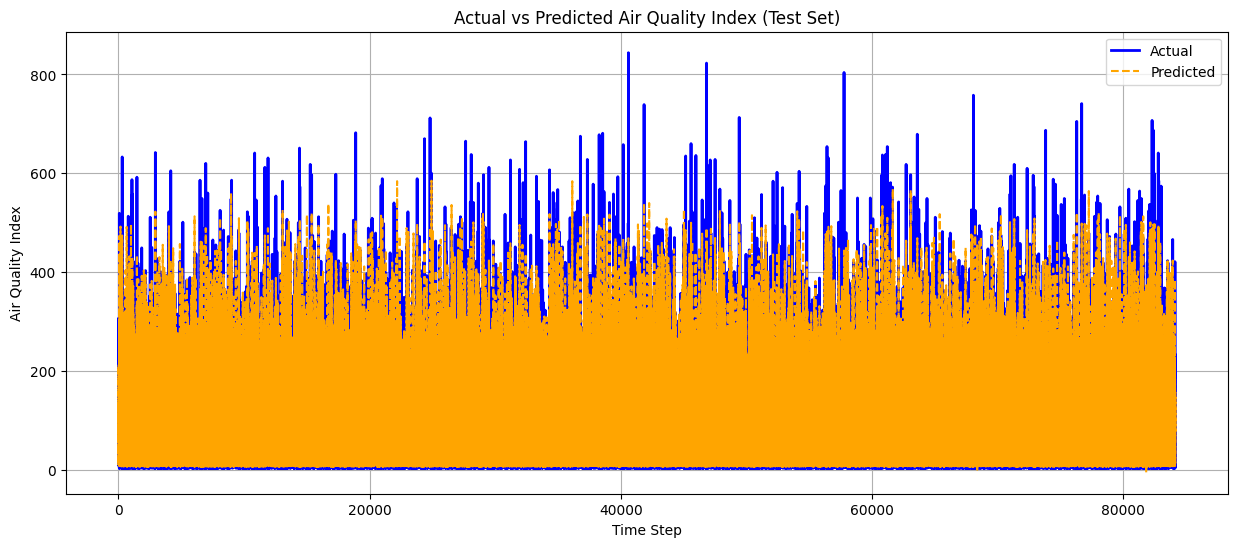

In [ ]:
import matplotlib.pyplot as plt

# Plot actual vs. predicted values for the test set
plt.figure(figsize=(15, 6))
plt.plot(range(len(y_test)), y_test, label="Actual", color='blue', linewidth=2)
plt.plot(range(len(y_pred_xgb)), y_pred_xgb, label="Predicted", color='orange', linestyle='--')
plt.title("Actual vs Predicted Air Quality Index (Test Set)")
plt.xlabel("Time Step")
plt.ylabel("Air Quality Index")
plt.legend()
plt.grid(True)
plt.show()


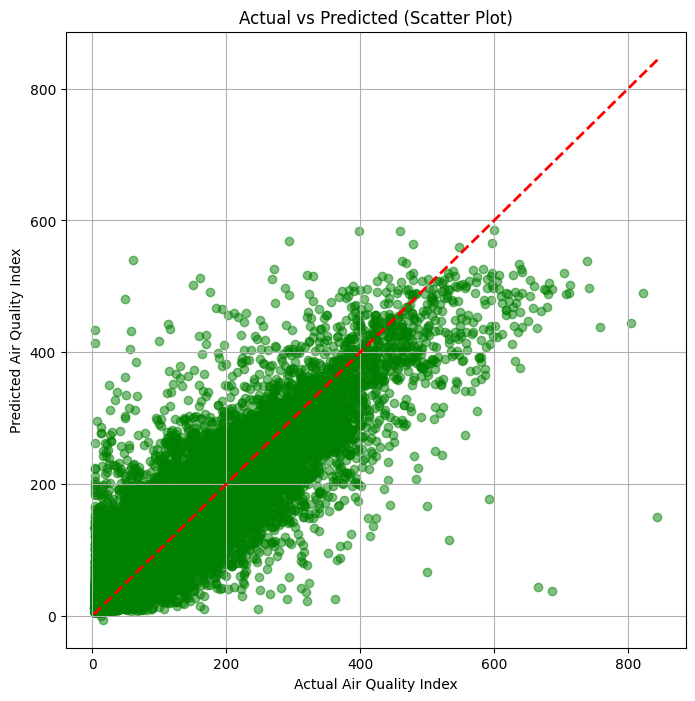

In [ ]:
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred_xgb, alpha=0.5, color='green')
plt.title("Actual vs Predicted (Scatter Plot)")
plt.xlabel("Actual Air Quality Index")
plt.ylabel("Predicted Air Quality Index")
plt.grid(True)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', linewidth=2)  # 45-degree line
plt.show()


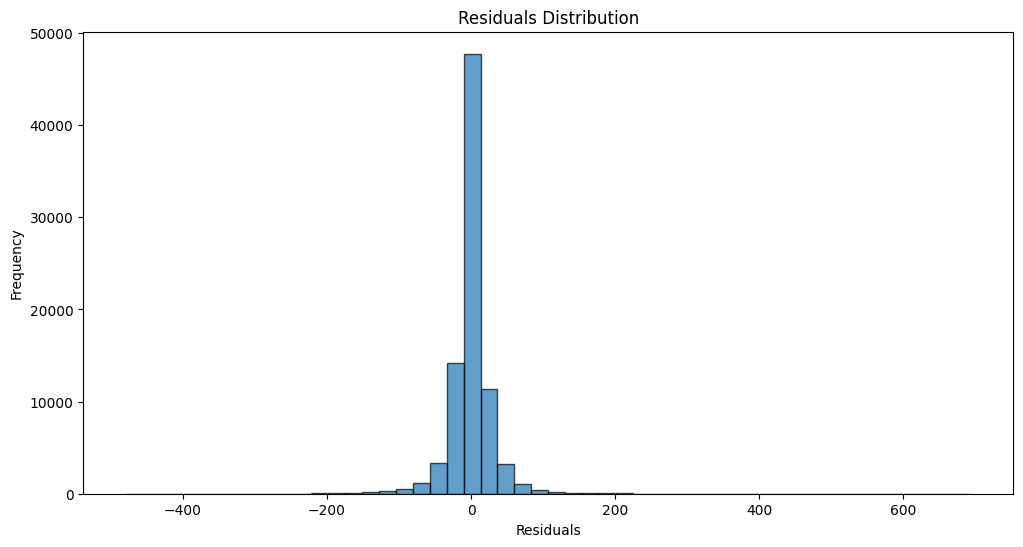

In [ ]:
import matplotlib.pyplot as plt
# Calculate residuals
residuals = y_test - y_pred_xgb  # No need for .values here since y_test is already a NumPy array

# Plot residuals
plt.figure(figsize=(12, 6))
plt.hist(residuals, bins=50, edgecolor='black', alpha=0.7)
plt.title('Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()


Length of y_test: 84150
Length of y_pred_xgb: 84150
Length of residuals: 84150


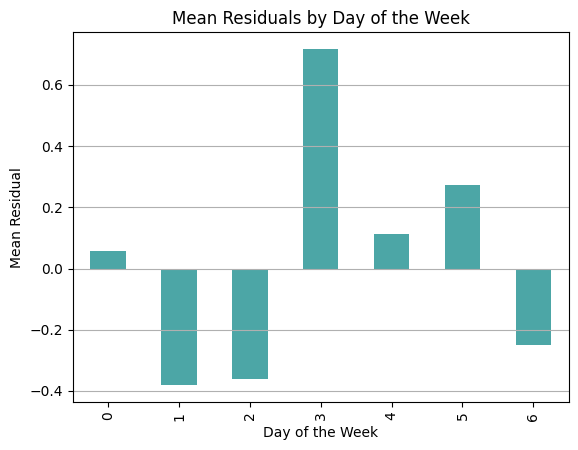

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Debug: Check lengths of arrays
print(f"Length of y_test: {len(y_test)}")
print(f"Length of y_pred_xgb: {len(y_pred_xgb)}")
print(f"Length of residuals: {len(residuals)}")

# Ensure all arrays are of the same length
min_length = min(len(y_test), len(y_pred_xgb), len(residuals))

# Slice to match the smallest length
y_test = y_test[:min_length]
y_pred_xgb = y_pred_xgb[:min_length]
residuals = residuals[:min_length]

# Create a DataFrame for analysis
results_df = pd.DataFrame({
    "Actual": y_test,
    "Predicted": y_pred_xgb,
    "Residuals": residuals
})

# Example: Analyze mean error by temporal dimension (e.g., weekday)
# Assuming you have a 'day_of_week' column in your original dataset
if 'day_of_week' in combined_data_cleaned.columns:
    # Align 'day_of_week' with the test dataset indices
    results_df['DayOfWeek'] = combined_data_cleaned.loc[y_test.index, 'day_of_week']

    # Calculate the mean residuals grouped by the day of the week
    mean_error_by_day = results_df.groupby('DayOfWeek')['Residuals'].mean()

    # Plot the mean residuals by day of the week
    mean_error_by_day.plot(kind='bar', color='teal', alpha=0.7)
    plt.title("Mean Residuals by Day of the Week")
    plt.xlabel("Day of the Week")
    plt.ylabel("Mean Residual")
    plt.grid(axis='y')
    plt.show()
else:
    print("'day_of_week' column not found in combined_data_cleaned.")


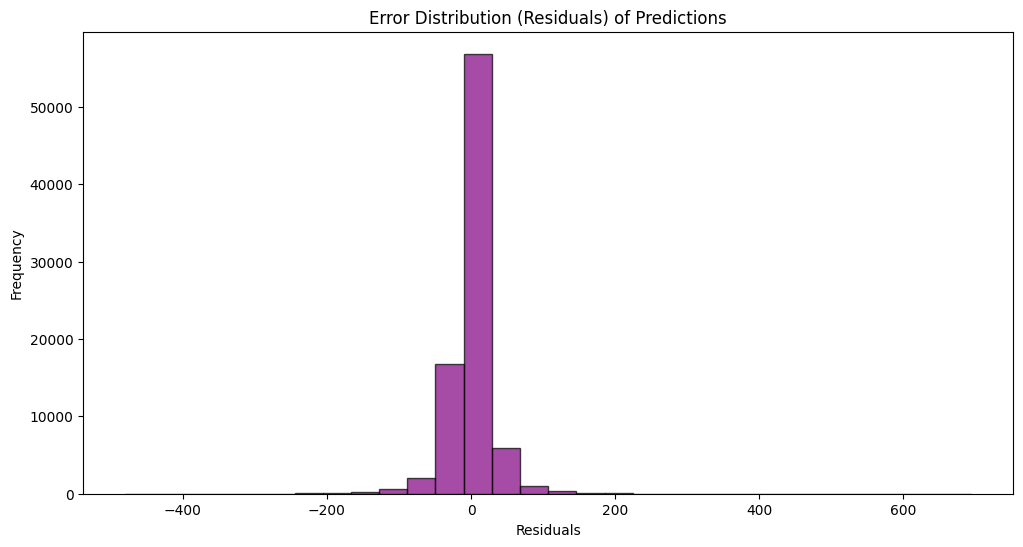

In [ ]:
# Plot distribution of residuals
plt.figure(figsize=(12, 6))
plt.hist(residuals, bins=30, color='purple', edgecolor='black', alpha=0.7)
plt.title('Error Distribution (Residuals) of Predictions')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()


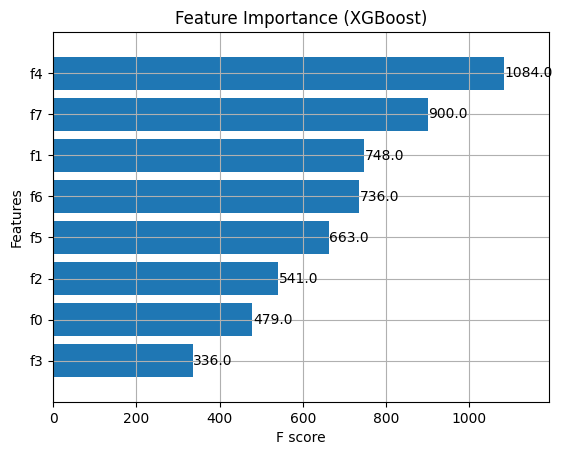

In [ ]:
import xgboost as xgb

# Retrieve feature importance
xgb.plot_importance(random_search.best_estimator_, importance_type='weight', max_num_features=10, height=0.8)
plt.title("Feature Importance (XGBoost)")
plt.show()


In [ ]:
combined_data_cleaned['datetime'] = pd.to_datetime(combined_data_cleaned['datetime'])  # Convert to datetime
combined_data_cleaned['weekday'] = combined_data_cleaned['datetime'].dt.weekday  # Extract weekday
combined_data_cleaned['hour'] = combined_data_cleaned['datetime'].dt.hour  # Extract hour


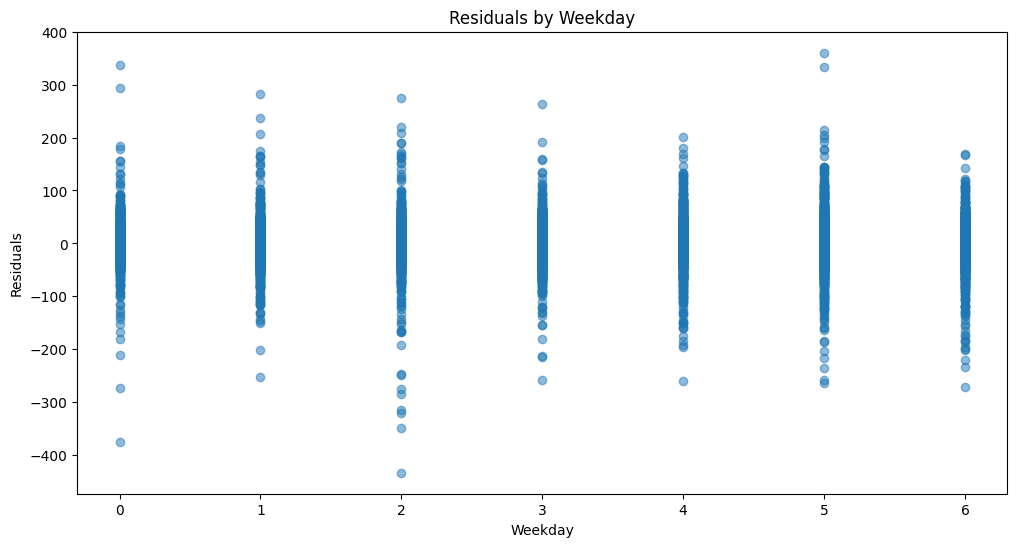

In [ ]:
# Assuming 'combined_data_cleaned' has a column 'weekday' (0=Monday, 6=Sunday)
combined_data_residuals = pd.DataFrame({
    'weekday': combined_data_cleaned['weekday'].iloc[len(combined_data_cleaned) - len(residuals):],  # align residuals with 'weekday'
    'residuals': residuals
})

plt.figure(figsize=(12, 6))
plt.scatter(combined_data_residuals['weekday'], combined_data_residuals['residuals'], alpha=0.5)
plt.title('Residuals by Weekday')
plt.xlabel('Weekday')
plt.ylabel('Residuals')
plt.show()


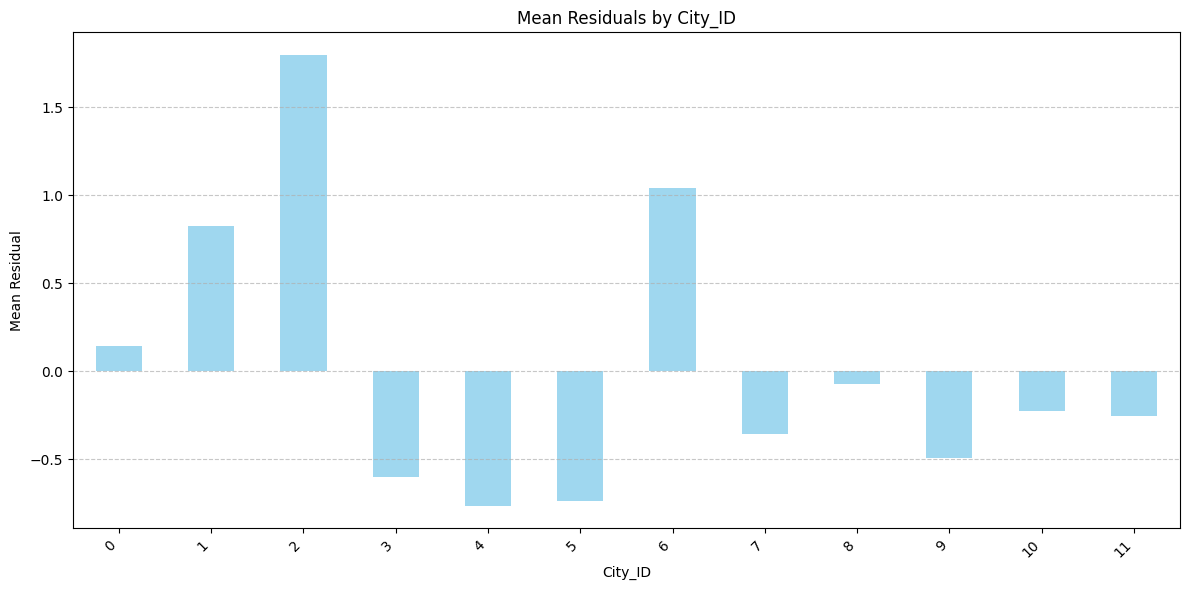

In [ ]:
# Check if 'city_id' column exists in the combined data
if 'city_id' in combined_data_cleaned.columns:
    # Align 'city_id' column with the test dataset indices
    results_df['City_ID'] = combined_data_cleaned.loc[y_test.index, 'city_id']

    # Calculate the mean residuals grouped by city_id
    mean_error_by_city = results_df.groupby('City_ID')['Residuals'].mean()

    # Plot the mean residuals by city_id
    mean_error_by_city.plot(kind='bar', color='skyblue', alpha=0.8, figsize=(12, 6))
    plt.title("Mean Residuals by City_ID")
    plt.xlabel("City_ID")
    plt.ylabel("Mean Residual")
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("'city_id' column not found in combined_data_cleaned.")


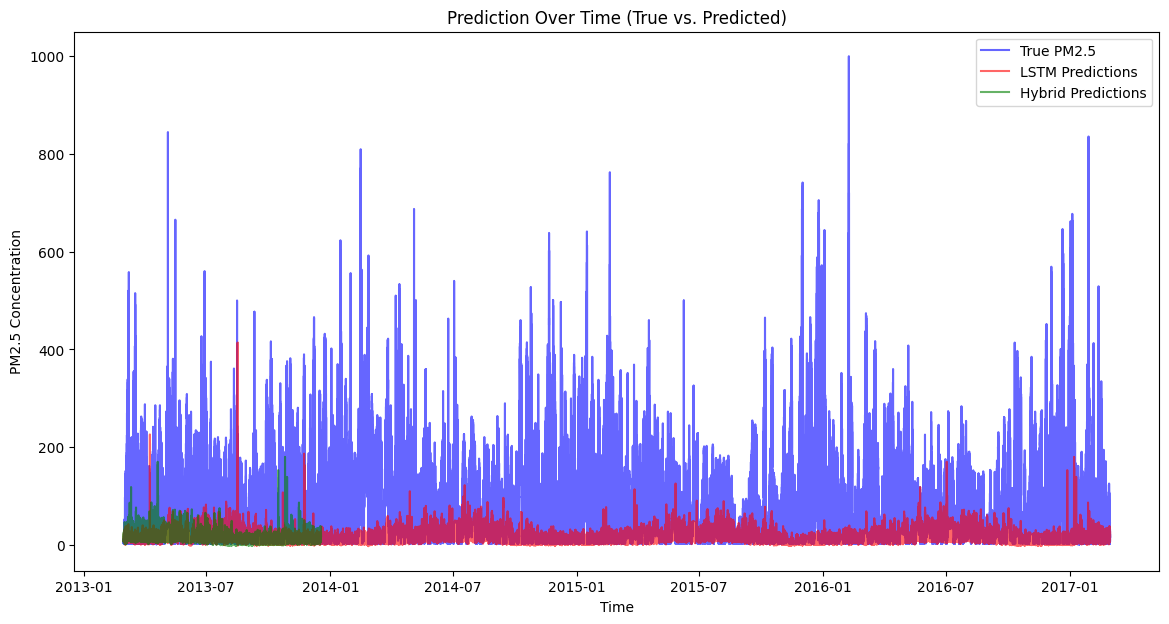

In [ ]:
import matplotlib.pyplot as plt

# Ensure 'datetime' is converted to pandas datetime type
combined_data_cleaned['datetime'] = pd.to_datetime(combined_data_cleaned['datetime'])

# Align LSTM and hybrid predictions with the 'datetime' column
lstm_preds_full = np.pad(lstm_preds, (0, len(combined_data_cleaned) - len(lstm_preds)), constant_values=np.nan)
hybrid_preds_full = np.pad(lstm_preds_test, (0, len(combined_data_cleaned) - len(lstm_preds_test)), constant_values=np.nan)

# Plot predictions over time
plt.figure(figsize=(14, 7))
plt.plot(combined_data_cleaned['datetime'], combined_data_cleaned['target_7_days_ahead'], label='True PM2.5', color='blue', alpha=0.6)
plt.plot(combined_data_cleaned['datetime'], lstm_preds_full, label='LSTM Predictions', color='red', alpha=0.6)
plt.plot(combined_data_cleaned['datetime'], hybrid_preds_full, label='Hybrid Predictions', color='green', alpha=0.6)
plt.title('Prediction Over Time (True vs. Predicted)')
plt.xlabel('Time')
plt.ylabel('PM2.5 Concentration')
plt.legend()
plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Identify non-numeric columns
non_numeric_cols = combined_data_cleaned.select_dtypes(include=['object']).columns
print("Non-Numeric Columns:", non_numeric_cols)

# Encode non-numeric columns, if necessary
for col in non_numeric_cols:
    combined_data_cleaned[col] = combined_data_cleaned[col].astype('category').cat.codes

# Verify dataset after encoding
print(combined_data_cleaned.info())


Non-Numeric Columns: Index(['wd', 'station', 'site'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
Index: 420754 entries, 35064 to 175319
Data columns (total 53 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   No                   420754 non-null  int64         
 1   year                 420754 non-null  int32         
 2   month                420754 non-null  int32         
 3   day                  420754 non-null  int32         
 4   hour                 420754 non-null  int32         
 5   PM2.5                420754 non-null  float64       
 6   PM10                 420754 non-null  float64       
 7   SO2                  420754 non-null  float64       
 8   NO2                  420754 non-null  float64       
 9   CO                   420754 non-null  float64       
 10  O3                   420754 non-null  float64       
 11  TEMP                 420754 non-null  float64       
 12  PRE

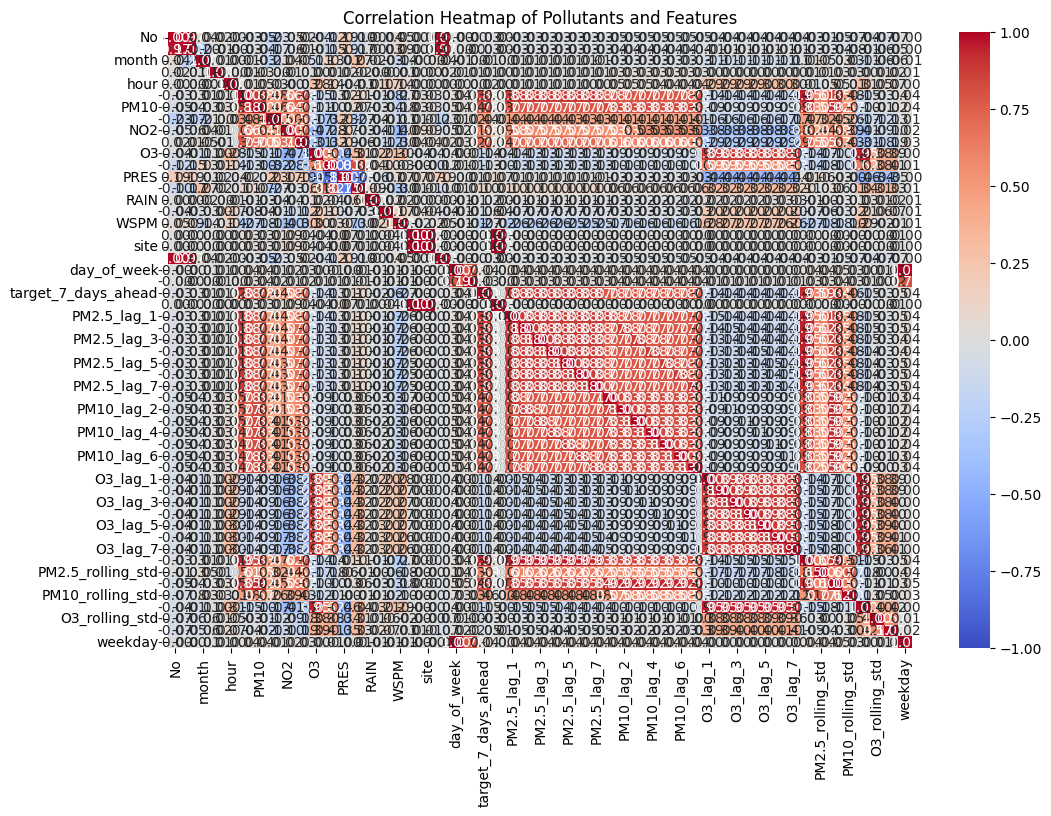

In [ ]:
# Compute correlation matrix for numeric data
correlation_matrix = combined_data_cleaned.corr()

# Plot the correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Heatmap of Pollutants and Features")
plt.show()


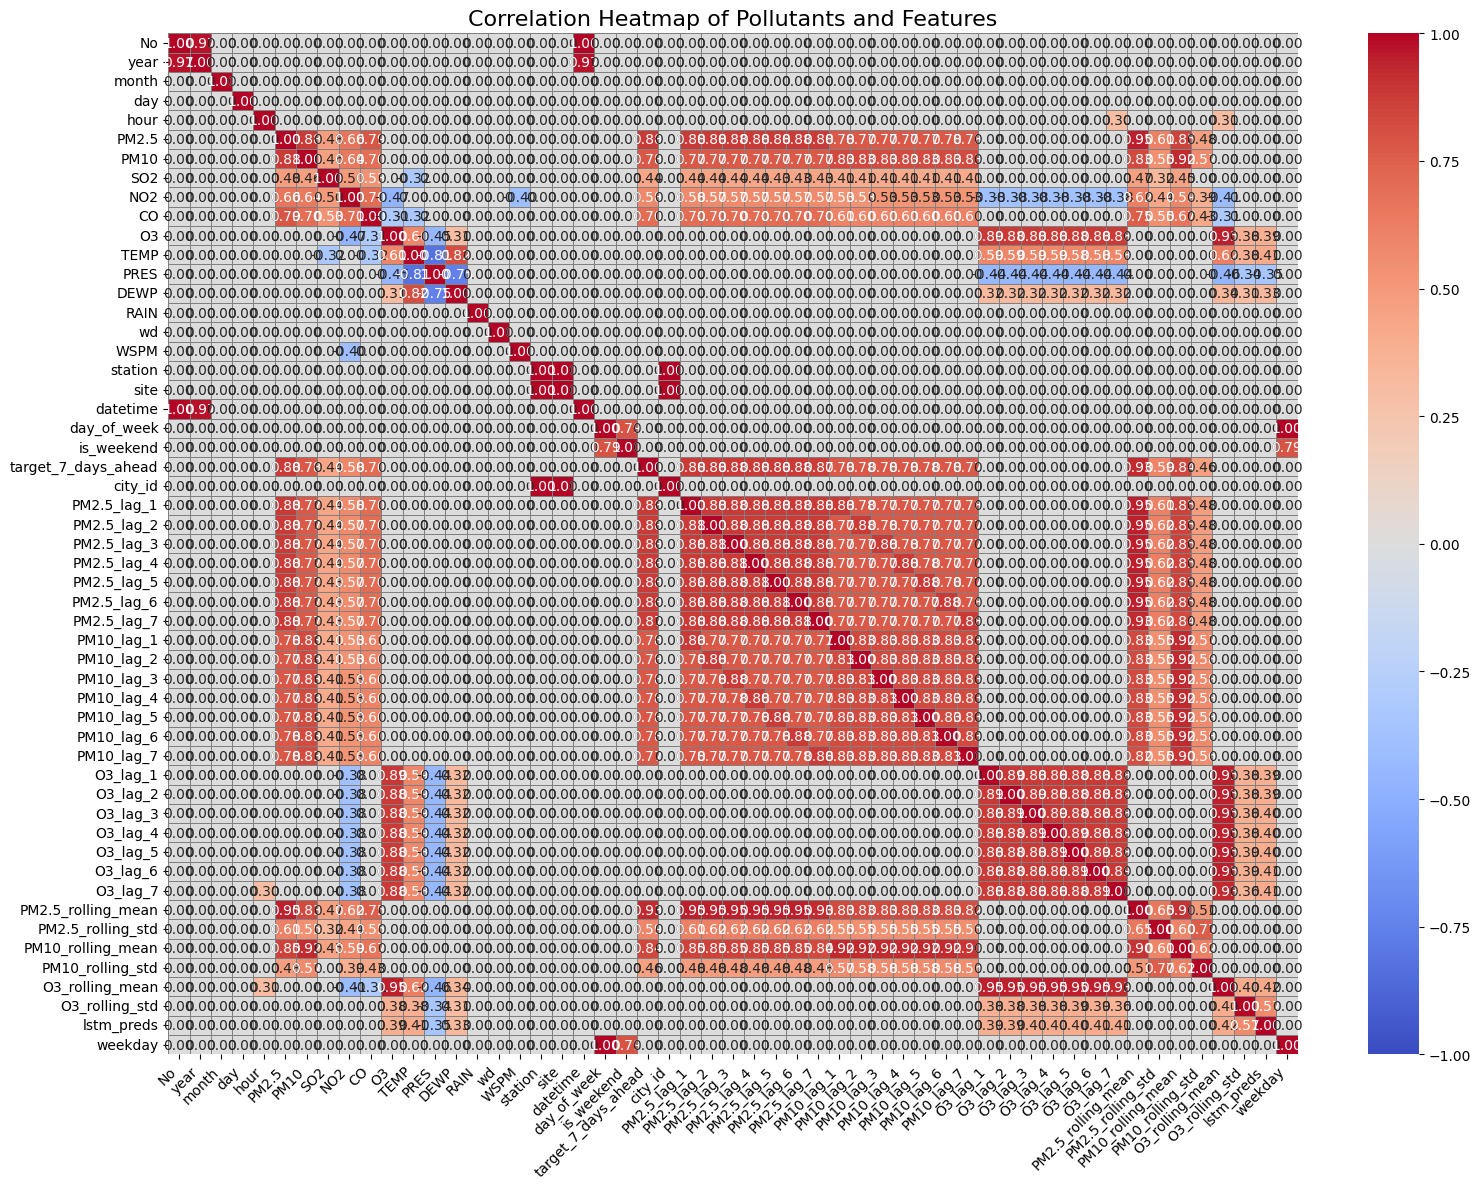

In [ ]:
import numpy as np

# Set a correlation threshold for filtering (optional, e.g., show only correlations > |0.3|)
correlation_threshold = 0.3
filtered_corr = correlation_matrix.copy()
filtered_corr[np.abs(filtered_corr) < correlation_threshold] = 0

# Plot heatmap with improvements
plt.figure(figsize=(16, 12))  # Increase figure size
sns.heatmap(filtered_corr, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1,
            linewidths=0.5, linecolor='gray')  # Add gridlines for clarity
plt.title("Correlation Heatmap of Pollutants and Features", fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=10)  # Rotate x-axis labels for readability
plt.yticks(fontsize=10)
plt.tight_layout()  # Adjust layout for better spacing
plt.show()


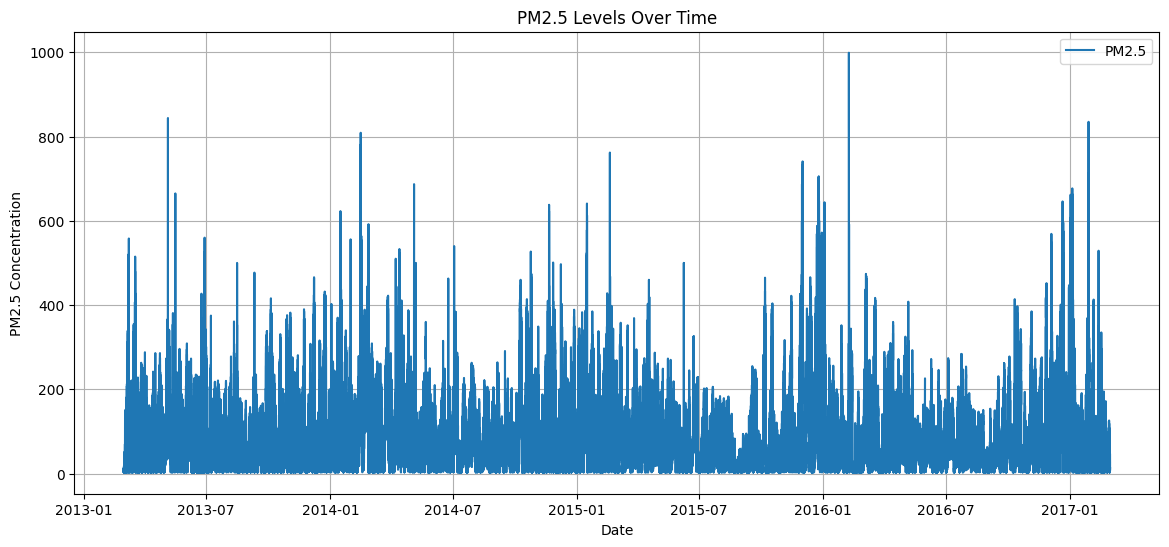

In [ ]:
# Example: Trend of PM2.5 across time
plt.figure(figsize=(14, 6))
plt.plot(combined_data_cleaned['datetime'], combined_data_cleaned['PM2.5'], label='PM2.5')
plt.title("PM2.5 Levels Over Time")
plt.xlabel("Date")
plt.ylabel("PM2.5 Concentration")
plt.legend()
plt.grid(True)
plt.show()


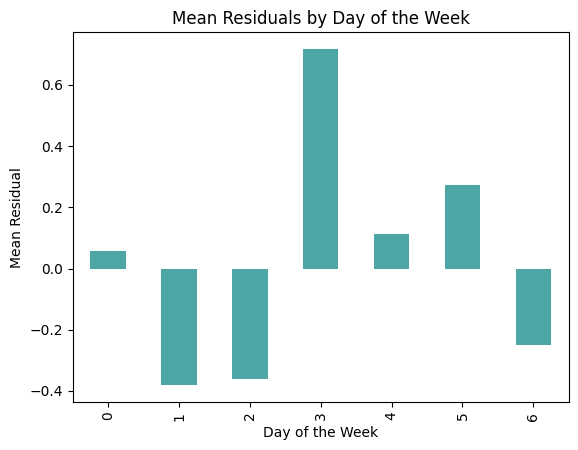

In [ ]:
# Calculate residuals
residuals = y_test - y_pred_xgb

# Add residuals to the dataframe
combined_data_cleaned['residual'] = residuals

# Analyze residuals by day of the week
if 'day_of_week' in combined_data_cleaned.columns:
    weekday_errors = combined_data_cleaned.groupby('day_of_week')['residual'].mean()
    weekday_errors.plot(kind='bar', color='teal', alpha=0.7)
    plt.title("Mean Residuals by Day of the Week")
    plt.xlabel("Day of the Week")
    plt.ylabel("Mean Residual")
    plt.show()


In [ ]:
# Combine X and y to drop rows with missing values
train_data = pd.concat([pd.DataFrame(X_train), pd.Series(y_train)], axis=1).dropna()
test_data = pd.concat([pd.DataFrame(X_test), pd.Series(y_test)], axis=1).dropna()

# Split back into X and y
X_train, y_train = train_data.iloc[:, :-1], train_data.iloc[:, -1]
X_test, y_test = test_data.iloc[:, :-1], test_data.iloc[:, -1]


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Train Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_lr = lr_model.predict(X_test)
rmse_lr = mean_squared_error(y_test, y_pred_lr, squared=False)
print(f"Linear Regression RMSE: {rmse_lr}")


Linear Regression RMSE: 30.497959654752187


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_rf = rf_model.predict(X_test)
rmse_rf = mean_squared_error(y_test, y_pred_rf, squared=False)
print(f"Random Forest RMSE: {rmse_rf}")


Random Forest RMSE: 30.842033991891064


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
import xgboost as xgb

# Train XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_xgb = xgb_model.predict(X_test)
rmse_xgb = mean_squared_error(y_test, y_pred_xgb, squared=False)
print(f"XGBoost RMSE: {rmse_xgb}")


XGBoost RMSE: 30.581482629289674


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


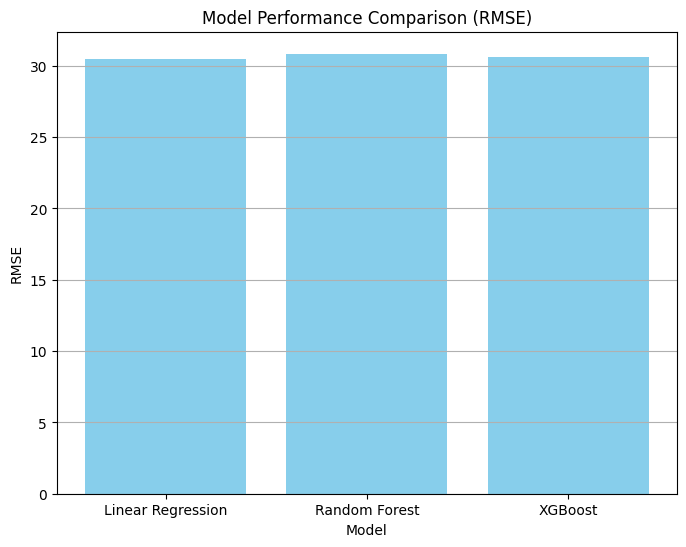

In [ ]:
# Define models and RMSEs
models = ['Linear Regression', 'Random Forest', 'XGBoost']
rmses = [rmse_lr, rmse_rf, rmse_xgb]

# Plot comparison
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.bar(models, rmses, color='skyblue')
plt.title("Model Performance Comparison (RMSE)")
plt.xlabel("Model")
plt.ylabel("RMSE")
plt.grid(axis='y')
plt.show()


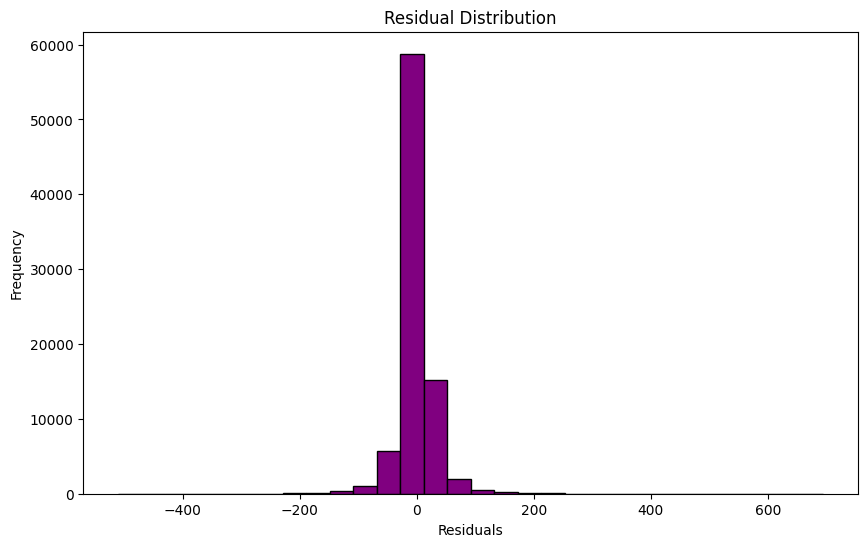

In [ ]:
# Residuals for the best model (e.g., XGBoost)
residuals = y_test - y_pred_xgb

# Plot residuals
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, color='purple', edgecolor='black')
plt.title("Residual Distribution")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()


In [ ]:
# Add residuals to test data
test_data['residuals'] = residuals

# Analyze residuals by day of the week
if 'day_of_week' in test_data.columns:
    weekday_residuals = test_data.groupby('day_of_week')['residuals'].mean()
    weekday_residuals.plot(kind='bar', color='teal', alpha=0.7)
    plt.title("Mean Residuals by Day of the Week")
    plt.xlabel("Day of the Week")
    plt.ylabel("Mean Residual")
    plt.show()


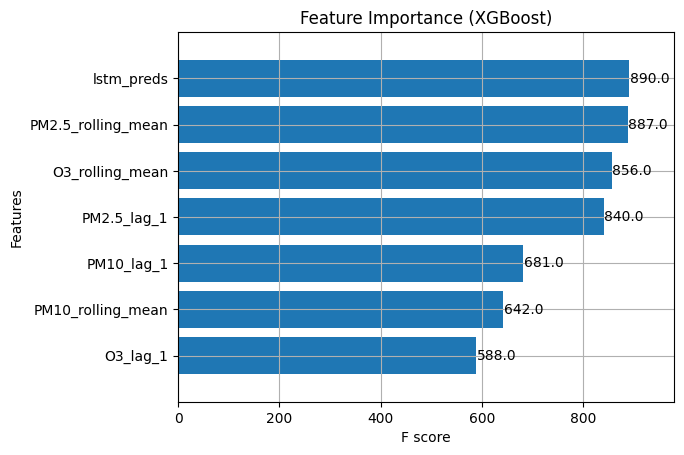

In [ ]:
# Feature importance for XGBoost
xgb.plot_importance(xgb_model, importance_type='weight', max_num_features=10, height=0.8)
plt.title("Feature Importance (XGBoost)")
plt.show()


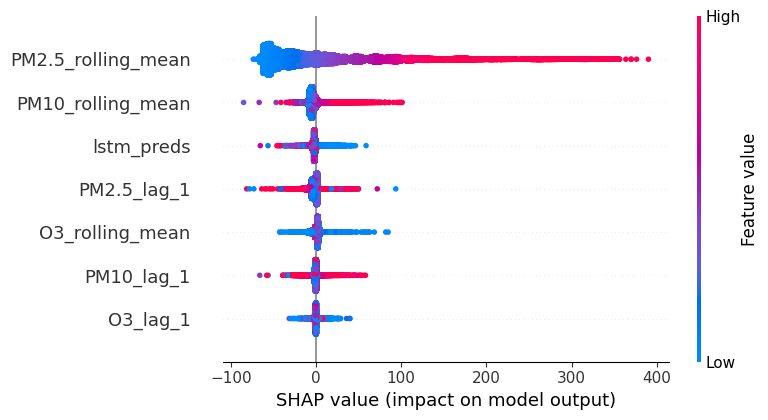

In [ ]:
import shap

# Initialize SHAP explainer
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)

# Plot summary of SHAP values
shap.summary_plot(shap_values, X_test)


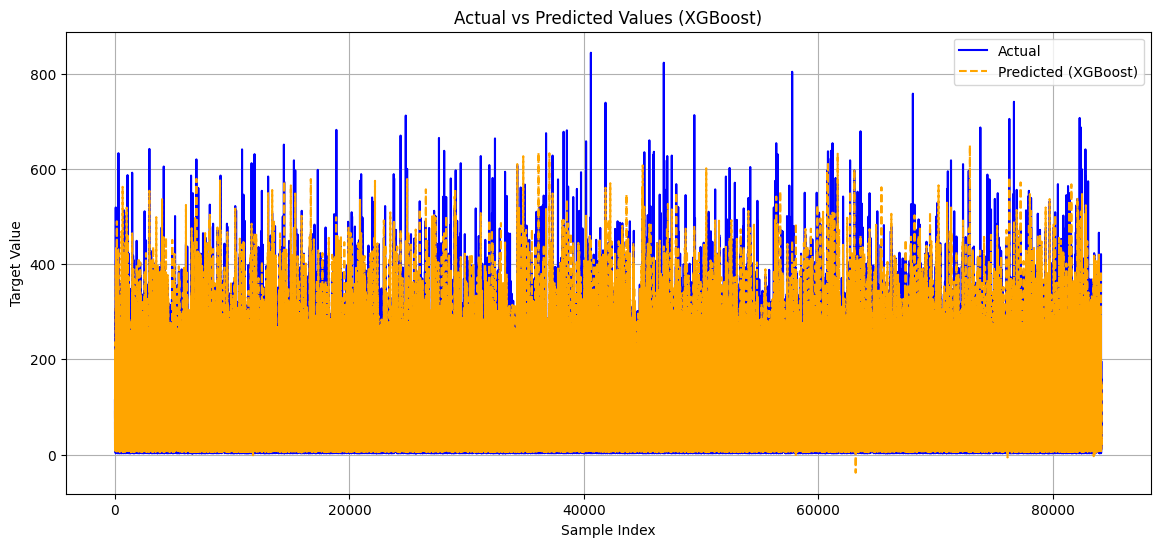

In [ ]:
import matplotlib.pyplot as plt

# Function to plot predictions vs actual values
def plot_predictions(y_actual, y_pred, model_name):
    plt.figure(figsize=(14, 6))
    plt.plot(range(len(y_actual)), y_actual, label="Actual", color='blue')
    plt.plot(range(len(y_pred)), y_pred, label=f"Predicted ({model_name})", color='orange', linestyle='--')
    plt.title(f"Actual vs Predicted Values ({model_name})")
    plt.xlabel("Sample Index")
    plt.ylabel("Target Value")
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage with XGBoost predictions
plot_predictions(y_test.values, y_pred_xgb, "XGBoost")


Training Linear Regression...


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Linear Regression RMSE: 30.4980
Training Random Forest...


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Random Forest RMSE: 30.8420
Training XGBoost...


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


XGBoost RMSE: 30.5815


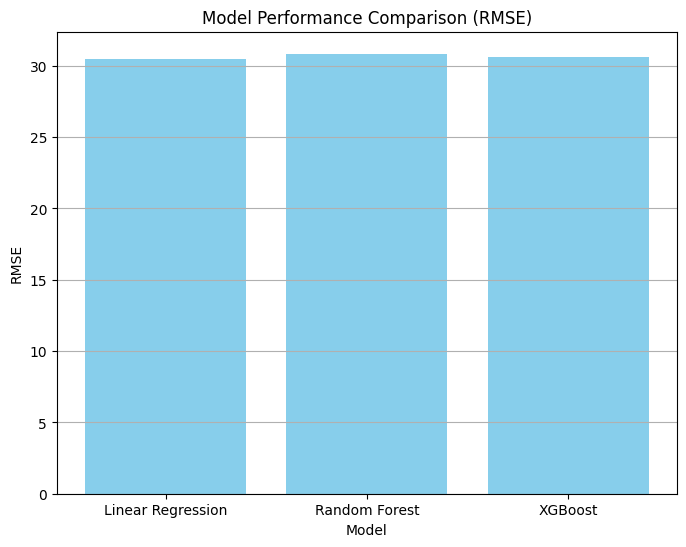

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# Function to train and evaluate multiple models
def evaluate_models(models, X_train, X_test, y_train, y_test):
    results = {}
    for model_name, model in models.items():
        print(f"Training {model_name}...")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        results[model_name] = rmse
        print(f"{model_name} RMSE: {rmse:.4f}")
    return results

# Define models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42),
}

# Evaluate models
results = evaluate_models(models, X_train, X_test, y_train, y_test)

# Visualize results
plt.figure(figsize=(8, 6))
plt.bar(results.keys(), results.values(), color='skyblue')
plt.title("Model Performance Comparison (RMSE)")
plt.xlabel("Model")
plt.ylabel("RMSE")
plt.grid(axis='y')
plt.show()
